<a href="https://colab.research.google.com/github/maxemileffort/paper-grading-assistant/blob/master/nlp_sentence_classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nlpaug

In [2]:
# Mount google drive first, then copy path to zip file
! unzip "/content/drive/MyDrive/kaggle data/feedback prize/train_data.zip" -d train

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize']=(15,8)
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras import layers

# Helper functions
import glob, os, re, shutil, string, sys
from joblib import dump, load
from PIL import Image
from sklearn import preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.svm import SVC
import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

# Contraction map
c_dict = {
    "ain't": "am not", "aren't": "are not","can't": "cannot",
    "can't've": "cannot have","'cause": "because","could've": "could have",
    "couldn't": "could not","couldn't've": "could not have",
    "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would",
    "he'd've": "he would have", "he'll": "he will",
    "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is",
    "i'd": "I would", "i'd've": "I would have",
    "i'll": "I will", "i'll've": "I will have",
    "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had",
    "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have","mightn't": "might not", 
    "mightn't've": "might not have", "must've": "must have", 
    "mustn't": "must not","mustn't've": "must not have", "needn't": "need not",
    "needn't've": "need not have", "o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have", "she'd": "she would",
    "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is",
    "should've": "should have","shouldn't": "should not",
    "shouldn't've": "should not have","so've": "so have",
    "so's": "so is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is",
    "there'd": "there had", "there'd've": "there would have",
    "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we had",
    "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have",
    "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have",
    "will've": "will have", "won't": "will not",
    "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have",
    "y'all": "you all", "y'alls": "you alls",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you had", "you'd've": "you would have",
    "you'll": "you you will", "you'll've": "you you will have",
    "you're": "you are", "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 
            'ad', 'ha', 'wa', 'reuters', 
            'just', 'cap']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))

# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    """ Called in process_text. """
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

def expand_contractions(text, c_re=c_re):
    """ Called in process_text. """
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [expand_contractions(each, c_re=c_re) for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", each) for each in text]
    text = [re.sub('[^a-zA-Z]', ' ', each) for each in text]
    text = [WordNetLemmatizer().lemmatize(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    # text = unique_words(text)
    return text

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def word_count(text):
    return len(str(text).split(' '))

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

Archive:  /content/drive/MyDrive/kaggle data/feedback prize/train_data.zip
replace train/out.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/out.csv           
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Check for GPU
# Runtime -> Change runtime type -> Hardware accelerator -> GPU.
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
data = pd.read_csv('train/out.csv')

In [5]:
# Split dataset into training, validation, and test splits
! pip install fast_ml

     |████████████████████████████████| 42 kB 368 kB/s 


In [6]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


## Checkpoint!

Retrain from the following cell, down. (Ctrl+F10)

In [7]:
from fast_ml.model_development import train_valid_test_split

train_df, train_label, val_df, val_label, test_df, test_label = train_valid_test_split(data, target = 'discourse_type_num', 
                                                                            train_size=0.7, valid_size=0.2, test_size=0.1)

In [8]:
train_df

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,predictionstring,char_len,sent_len,discourse_word_tokens,total_lines,line_number
34878,67C8EC23C79F,1.616261e+12,926.0,1422.0,If I am having a bad day or if I am tired from...,Evidence,154 155 156 157 158 159 160 161 162 163 164 16...,496.0,93,"['having', 'bad', 'day', 'tired', 'studying', ...",9,5
70806,4BC4DC58DB30,1.617034e+12,17.0,198.0,My view on this rule is that you should allow ...,Position,2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...,181.0,34,"['view', 'rule', 'allow', 'student', 'average'...",7,1
21472,F21CBEE52702,1.619108e+12,123.0,165.0,the students should design these project,Position,20 21 22 23 24 25,42.0,6,"['student', 'design', 'project']",7,2
137336,5C2F188C0177,1.617806e+12,396.0,547.0,someone elses opinion can keep you from doing...,Claim,73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 8...,151.0,27,"['el', 'opinion', 'doing', 'thing', 'suppose',...",12,6
118313,2FA2ABCDD456,1.621950e+12,2488.0,2564.0,There are some people that claim that being ho...,Counterclaim,454 455 456 457 458 459 460 461 462 463 464 46...,76.0,13,"['people', 'claim', 'home', 'schooled', 'benef...",10,8
...,...,...,...,...,...,...,...,...,...,...,...,...
41418,48984D541995,1.616507e+12,2577.0,3122.0,"Throughout the article, it suggests that study...",Concluding Statement,421 422 423 424 425 426 427 428 429 430 431 43...,545.0,81,"['article', 'suggests', 'studying', 'venus', '...",9,9
249,62644C50869C,1.622907e+12,334.0,355.0,Injuring a pedestrian,Claim,58 59 60,21.0,3,"['injuring', 'pedestrian']",13,5
16130,BCA9ED73877E,1.618789e+12,443.0,495.0,they can have their own personality to their p...,Claim,73 74 75 76 77 78 79 80 81,52.0,9,"['personality', 'project']",12,3
121403,9A40D1576A1E,1.621440e+12,1340.0,1568.0,Human interaction is some what needed to prefo...,Claim,240 241 242 243 244 245 246 247 248 249 250 25...,228.0,42,"['human', 'interaction', 'needed', 'preform', ...",13,9


In [9]:
train_label

34878                 Evidence 1
70806                 Position 1
21472                 Position 1
137336                   Claim 4
118313            Counterclaim 1
                   ...          
41418     Concluding Statement 1
249                      Claim 2
16130                    Claim 1
121403                   Claim 5
83889                     Lead 1
Name: discourse_type_num, Length: 101005, dtype: object

In [11]:
aug_df = train_df.copy()
aug_df['discourse_type_num'] = train_label
aug_df

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,predictionstring,char_len,sent_len,discourse_word_tokens,total_lines,line_number,discourse_type_num
34878,67C8EC23C79F,1.616261e+12,926.0,1422.0,If I am having a bad day or if I am tired from...,Evidence,154 155 156 157 158 159 160 161 162 163 164 16...,496.0,93,"['having', 'bad', 'day', 'tired', 'studying', ...",9,5,Evidence 1
70806,4BC4DC58DB30,1.617034e+12,17.0,198.0,My view on this rule is that you should allow ...,Position,2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...,181.0,34,"['view', 'rule', 'allow', 'student', 'average'...",7,1,Position 1
21472,F21CBEE52702,1.619108e+12,123.0,165.0,the students should design these project,Position,20 21 22 23 24 25,42.0,6,"['student', 'design', 'project']",7,2,Position 1
137336,5C2F188C0177,1.617806e+12,396.0,547.0,someone elses opinion can keep you from doing...,Claim,73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 8...,151.0,27,"['el', 'opinion', 'doing', 'thing', 'suppose',...",12,6,Claim 4
118313,2FA2ABCDD456,1.621950e+12,2488.0,2564.0,There are some people that claim that being ho...,Counterclaim,454 455 456 457 458 459 460 461 462 463 464 46...,76.0,13,"['people', 'claim', 'home', 'schooled', 'benef...",10,8,Counterclaim 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41418,48984D541995,1.616507e+12,2577.0,3122.0,"Throughout the article, it suggests that study...",Concluding Statement,421 422 423 424 425 426 427 428 429 430 431 43...,545.0,81,"['article', 'suggests', 'studying', 'venus', '...",9,9,Concluding Statement 1
249,62644C50869C,1.622907e+12,334.0,355.0,Injuring a pedestrian,Claim,58 59 60,21.0,3,"['injuring', 'pedestrian']",13,5,Claim 2
16130,BCA9ED73877E,1.618789e+12,443.0,495.0,they can have their own personality to their p...,Claim,73 74 75 76 77 78 79 80 81,52.0,9,"['personality', 'project']",12,3,Claim 1
121403,9A40D1576A1E,1.621440e+12,1340.0,1568.0,Human interaction is some what needed to prefo...,Claim,240 241 242 243 244 245 246 247 248 249 250 25...,228.0,42,"['human', 'interaction', 'needed', 'preform', ...",13,9,Claim 5


In [10]:
check_gpu = tf.test.gpu_device_name()
check_gpu

''

In [12]:
!pip install transformers
import nlpaug.augmenter.word as naw

# main parameters to adjust
ACTION = 'substitute' # or use 'insert'
TOP_K = 15 # randomly draw from top 15 suggested words
AUG_P = 0.40 # augment 40% of words within text

if 'GPU' in check_gpu:
  aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', 
    device='cuda',
    action=ACTION, 
    top_k=TOP_K,
    aug_p=AUG_P
    )
else:
  aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', 
    action=ACTION, 
    top_k=TOP_K,
    aug_p=AUG_P
    )

     |████████████████████████████████| 3.5 MB 16.1 MB/s 
     |████████████████████████████████| 596 kB 60.6 MB/s 
     |████████████████████████████████| 6.8 MB 41.8 MB/s 
     |████████████████████████████████| 895 kB 66.3 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [13]:
dtn_vals = list(aug_df['discourse_type_num'].unique())
print(dtn_vals)

['Evidence 1', 'Position 1', 'Claim 4', 'Counterclaim 1', 'Claim 6', 'Evidence 2', 'Claim 5', 'Claim 3', 'Claim 2', 'Lead 1', 'Concluding Statement 1', 'Evidence 5', 'Evidence 4', 'Evidence 3', 'Claim 1', 'Rebuttal 1', 'Evidence 7', 'Counterclaim 2', 'Rebuttal 3', 'Position 2', 'Evidence 6', 'Rebuttal 2', 'Claim 7', 'Counterclaim 3', 'Counterclaim 4', 'Counterclaim 5', 'Concluding Statement 2', 'Claim 8', 'Claim 12', 'Evidence 8', 'Claim 9', 'Claim 10', 'Claim 11', 'Lead 2', 'Evidence 10', 'Evidence 9', 'Concluding Statement 4', 'Rebuttal 4', 'Evidence 11', 'Rebuttal 5', 'Counterclaim 6', 'Rebuttal 6', 'Concluding Statement 3', 'Evidence 12']


In [ ]:
for val in dtn_vals:
  if 'GPU' in check_gpu:
    print(val)
    filt = aug_df['discourse_type_num'] == val
    text = list(aug_df.loc[filt, 'discourse_text'])
    if len(text) > 4*1000:
      continue
    augmented_text = aug_bert.augment(text) 
    data2 = aug_df.copy()
    data2.loc[filt, 'discourse_text'] = augmented_text
    aug_df = aug_df.append(data2)

  else:
    print(val)
    filt = aug_df['discourse_type_num'] == val
    new_df = aug_df.loc[filt]
    print("length of new_df:", len(new_df))
    if len(new_df) > 4*1000:
      continue
    new_df['aug_text'] = new_df['discourse_text'].apply(aug_bert.augment)
    new_df = new_df.drop(columns=['discourse_text'])
    new_df = new_df.rename(columns={'aug_text': 'discourse_text'})
    aug_df = aug_df.append(new_df)

Evidence 1
length of new_df: 10969
Position 1
length of new_df: 10825
Claim 4
length of new_df: 3957
Counterclaim 1
length of new_df: 3238
Claim 6
length of new_df: 1857
Evidence 2
length of new_df: 9779
Claim 5
length of new_df: 2442
Claim 3
length of new_df: 6848
Claim 2
length of new_df: 9265
Lead 1
length of new_df: 6469
Concluding Statement 1
length of new_df: 9345
Evidence 5
length of new_df: 918
Evidence 4
length of new_df: 2673


In [ ]:
aug_df.head()

In [ ]:
train_df = aug_df.copy()
train_df = train_df.drop(columns=['discourse_type_num'])

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
aug_df.to_csv('out.zip', index=False,
          compression=compression_opts)  

from google.colab import files
files.download('out.zip')

In [ ]:
# onehot encode dimensions
total_line_depth, line_number_depth = 18,14

# Create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_depth)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=line_number_depth)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_depth)
# Create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=total_line_depth)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=total_line_depth)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=total_line_depth)

# label encode target
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
enc_labels = data['discourse_type_num']
label_encoder = LabelEncoder()
label_encoder.fit(enc_labels.to_numpy())
train_labels_encoded = label_encoder.transform(train_label.to_numpy())
val_labels_encoded = label_encoder.transform(val_label.to_numpy())
test_labels_encoded = label_encoder.transform(test_label.to_numpy())

# onehot encode target (for label smoothing)
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(enc_labels.to_numpy().reshape(-1, 1))
train_labels_one_hot = one_hot_encoder.transform(train_label.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_label.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_label.to_numpy().reshape(-1, 1))

In [ ]:
max_word_tokens = 47614 # Our max vocab, calculated above
output_seq_char_len = int(np.percentile(data['char_len'], 95))
output_seq_sent_len = int(np.percentile(data['sent_len'], 95))

train_sentences = train_df["discourse_text"].tolist()
val_sentences = val_df["discourse_text"].tolist()
test_sentences = test_df["discourse_text"].tolist()

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

# Get all keyboard characters for char-level embedding
import string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

alphabet = string.ascii_lowercase + string.digits + string.punctuation
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up the model if set to True)
                              name="char_embed")



text_vectorizer = TextVectorization(max_tokens=max_word_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_sent_len) # desired output length of vectorized sequences

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_df['discourse_text'])

In [ ]:
# shape variables so model knows how to use them
train_sentences = pd.Series(train_sentences).to_numpy()
train_chars = pd.Series(train_chars).to_numpy()
val_sentences = pd.Series(val_sentences).to_numpy()
val_chars = pd.Series(val_chars).to_numpy()
test_sentences = pd.Series(test_sentences).to_numpy()
test_chars = pd.Series(test_chars).to_numpy()

In [ ]:
train_sentences.shape, train_chars.shape

((101005,), (101005,))

In [ ]:
output_layer_nodes = len(label_encoder.classes_)

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(14,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(18,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(output_layer_nodes, activation="softmax", name="output_layer")(z)

# 8. Put together model
model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

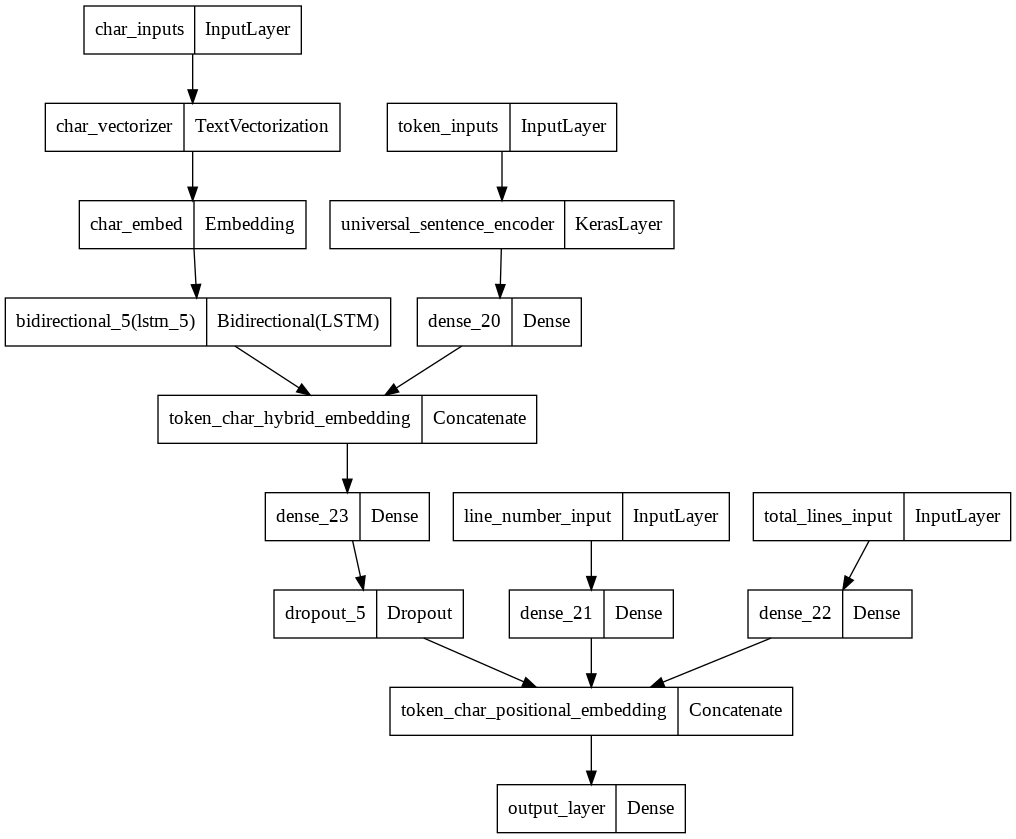

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# Compile token, char, positional embedding model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [ ]:
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 14), (None, 18), (None,), (None,)), (None, 44)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 14), (None, 18), (None,), (None,)), (None, 44)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit the token, char and positional embedding model
history_model = model.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.5* len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.5* len(val_pos_char_token_dataset)))

history_model = model.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.5* len(train_pos_char_token_dataset)),
                              epochs=3)

Epoch 1/3
1578/1578 [==============================] - 94s 57ms/step - loss: 2.3753 - accuracy: 0.4869
Epoch 2/3
1578/1578 [==============================] - 89s 57ms/step - loss: 2.1751 - accuracy: 0.5704
Epoch 3/3
   1/1578 [..............................] - ETA: 1:36 - loss: 1.7996 - accuracy: 0.7692WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 4734 batches). You may need to use the repeat() function when building your dataset.


1578/1578 [==============================] - 0s 34us/step - loss: 1.7996 - accuracy: 0.7692


In [ ]:
# Make predictions with test set
model_pred_probs = model.predict(test_pos_char_token_dataset, verbose=1)
model_pred_probs

451/451 [==============================] - 16s 34ms/step


array([[0.30198526, 0.00510502, 0.00509433, ..., 0.00567641, 0.00509027,
        0.00506813],
       [0.5271695 , 0.00587235, 0.00459238, ..., 0.00505157, 0.00438181,
        0.00463398],
       [0.00284349, 0.00516693, 0.00492861, ..., 0.00596554, 0.00510883,
        0.00510169],
       ...,
       [0.01221304, 0.00547394, 0.00485413, ..., 0.00621489, 0.00499362,
        0.00499523],
       [0.01615927, 0.00452619, 0.00454443, ..., 0.0045437 , 0.0045206 ,
        0.00466856],
       [0.02501632, 0.00413177, 0.00472217, ..., 0.00481266, 0.00471922,
        0.00473014]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_preds = tf.argmax(model_pred_probs, axis=1)
model_preds

<tf.Tensor: shape=(14430,), dtype=int64, numpy=array([22,  0, 12, ...,  8,  6, 22])>

In [ ]:
# Calculate results of model
model_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_preds)
model_results

{'accuracy': 58.11503811503812,
 'f1': 0.5686308350404475,
 'precision': 0.5692891123291846,
 'recall': 0.5811503811503812}

In [ ]:
test_pred_classes = [label_encoder.classes_[pred] for pred in model_preds]
test_pred_classes[:5]

['Evidence 1',
 'Claim 1',
 'Concluding Statement 1',
 'Counterclaim 1',
 'Evidence 2']

In [ ]:
def check_preds(prediction):
  checker = prediction.split(' ')
  if len(checker) > 2:
    return f'{checker[0]} {checker[1]}'
  else:
    return checker[0]

# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["prediction"] = test_df["prediction"].apply(check_preds) # remove the numbers
test_df["pred_prob"] = tf.reduce_max(model_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df['discourse_type'] # create binary column for whether the prediction is right or not
try:
  test_df = test_df.drop(columns=['discourse_id', 'discourse_start', 'discourse_end'])
except:
  pass
test_df.head(20)

,id,discourse_text,discourse_type,predictionstring,char_len,sent_len,discourse_word_tokens,total_lines,line_number,prediction,pred_prob,correct
130061,EF9D79A33BE7,I say this because asking more than one person...,Evidence,49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 6...,255.0,50,"['asking', 'person', 'help', 'trying', 'way', ...",8,3,Evidence,0.305451,True
113946,26F0870BE37F,"as it can reduce social skills and interaction,",Claim,71 72 73 74 75 76 77 78,47.0,8,"['reduce', 'social', 'skill', 'interaction']",17,3,Claim,0.527170,True
6519,B31E67E692E4,I feel like there is no text that is importan...,Evidence,240 241 242 243 244 245 246 247 248 249 250 25...,366.0,71,"['feel', 'text', 'important', 'risk', 'life', ...",13,10,Concluding Statement,0.238262,False
99189,06A2C91F38FE,"In contrast, it can be argued that no single r...",Counterclaim,322 323 324 325 326 327 328 329 330 331 332 33...,81.0,15,"['contrast', 'argued', 'single', 'region', 'sh...",10,8,Counterclaim,0.159146,True
32146,44588DAF5A33,"Some of these activities, like drama and sport...",Claim,255 256 257 258 259 260 261 262 263 264 265 26...,195.0,37,"['activity', 'drama', 'sport', 'place', 'schoo...",10,5,Evidence,0.304389,False
100575,9C6A5CA37B5F,"As said in the text "" In a 2000 campaign , se...",Evidence,294 295 296 297 298 299 300 301 302 303 304 30...,409.0,77,"['text', 'campaign', 'seventeen', 'state', 'do...",8,6,Evidence,0.426827,True
20464,0A43A08B43DA,The whole point for the projects are to educat...,Evidence,253 254 255 256 257 258 259 260 261 262 263 26...,295.0,54,"['point', 'project', 'educate', 'student', 'le...",18,11,Concluding Statement,0.523994,False
33973,7E873F1E93C2,"In the end, the rule should be passed and all ...",Concluding Statement,945 946 947 948 949 950 951 952 953 954 955 95...,250.0,40,"['end', 'rule', 'passed', 'student', 'required...",14,14,Concluding Statement,0.237333,True
112532,F10231811C61,It decreases the time to finish work at home r...,Evidence,420 421 422 423 424 425 426 427 428 429 430 43...,773.0,143,"['decrease', 'time', 'finish', 'work', 'home',...",14,11,Evidence,0.346154,True
72053,3B55EC92FAAF,"When the students try to succeed in anything, ...",Evidence,207 208 209 210 211 212 213 214 215 216 217 21...,336.0,64,"['student', 'try', 'succeed', 'effort', 'actua...",12,7,Evidence,0.249440,True


In [ ]:
len(test_df), len(test_df.loc[test_df.correct == False])

(14430, 3012)

In [ ]:
1 - len(test_df.loc[test_df.correct == False]) / len(test_df)

0.7912681912681913

In [ ]:
# Find top 100 most wrong samples 
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,id,discourse_text,discourse_type,predictionstring,char_len,sent_len,discourse_word_tokens,total_lines,line_number,prediction,pred_prob,correct
84929,2827667B4662,I think you will agree with me.,Lead,26 27 28 29 30 31 32,32.0,7,"['think', 'agree']",7,1,Position,0.871740,False
38907,144FB09B0949,The author made really good points about why w...,Claim,25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 4...,105.0,19,"['author', 'really', 'good', 'point', 'study',...",5,2,Position,0.849054,False
130113,71A690B6C0D6,When people in a group share ideas it will mak...,Position,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,194.0,41,"['people', 'group', 'share', 'idea', 'make', '...",9,1,Lead,0.845383,False
76783,03259FDA2D4E,I think that this cars are not safe,Claim,29 30 31 32 33 34 35 36,35.0,8,"['think', 'car', 'safe']",8,2,Position,0.833521,False
140122,E7E7F9BA0F30,Seeking multiple opinions can help because it ...,Claim,38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 5...,108.0,17,"['seeking', 'multiple', 'opinion', 'help', 'al...",8,2,Position,0.819170,False
...,...,...,...,...,...,...,...,...,...,...,...,...
14520,3009A8F385F7,People have poluted there self by there on han...,Position,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,164.0,32,"['people', 'poluted', 'self', 'hand', 'car', '...",2,1,Lead,0.636215,False
6554,4B96AA0C1382,The laws regulating driving while on your phon...,Evidence,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,250.0,43,"['law', 'regulating', 'driving', 'phone', 'sub...",7,1,Lead,0.634976,False
58118,F2A79A33B020,"Contrary to popular belief, there is nothing u...",Position,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,325.0,53,"['contrary', 'popular', 'belief', 'unatural', ...",10,1,Lead,0.634688,False
139387,2ACB43DD4A24,Seeking advice from multiple people will give ...,Claim,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17,102.0,18,"['seeking', 'advice', 'multiple', 'people', 's...",8,1,Position,0.633995,False


In [ ]:
try:
  !mkdir models
except:
  pass
model.save("models/feedback_prize_model")

mkdir: cannot create directory ‘models’: File exists


INFO:tensorflow:Assets written to: models/feedback_prize_model/assets


INFO:tensorflow:Assets written to: models/feedback_prize_model/assets


In [ ]:
! cp model.png /content/models
!zip -r /content/model.zip /content/models

updating: content/models/ (stored 0%)
updating: content/models/model.png (deflated 15%)
updating: content/models/feedback_prize_model/ (stored 0%)
updating: content/models/feedback_prize_model/saved_model.pb (deflated 72%)
updating: content/models/feedback_prize_model/variables/ (stored 0%)
updating: content/models/feedback_prize_model/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/models/feedback_prize_model/variables/variables.index (deflated 77%)
updating: content/models/feedback_prize_model/assets/ (stored 0%)
updating: content/models/feedback_prize_model/keras_metadata.pb (deflated 91%)


In [ ]:
from google.colab import files
files.download('model.zip')